# Time series forecasting example1
In this example we will look at forecasting future temperature from historic weather data.
The data is obtained from: https://www.southamptonweather.co.uk/wxtempsummary.php

For time-series-forecasting, the below steps should be followed:

get data

-- explore the data and look for any seasonality, and use data decomposition

-- check for to see if stationary

-- if not apply transformations

-- set d equal to number of times series differenced (for ARIMA or SARIMA)

-- set D equal to the number of times seasonal differencing was applied

-- list values of p and q

-- fit every combination of ARIMA (p,d,q) or SARIMA (p,d,q)(P,D,Q,m)

-- select model with lowest AIC

-- residual analysis

check:

-- q-q plot shows straight line

-- uncorrelated residuals

then ready for forecasts

In [1]:
# Load the required packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import xlsxwriter as xlw
import os
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Get data

In [2]:
# setup
file_name = 'C:\\Users\\kelvi\\Desktop\\southampton_wxr.xlsx' # train/test on existing data

#open file
df = pd.read_excel(file_name)#, skiprows=4,sheet_name='test')

#rename col of interest to 'test'
df.rename(columns={'temp':'test'},inplace=True) # here we are looking at / predicting temp (or temperature)

# make date as df index...?
# df.set_index('date')

# Explore the data

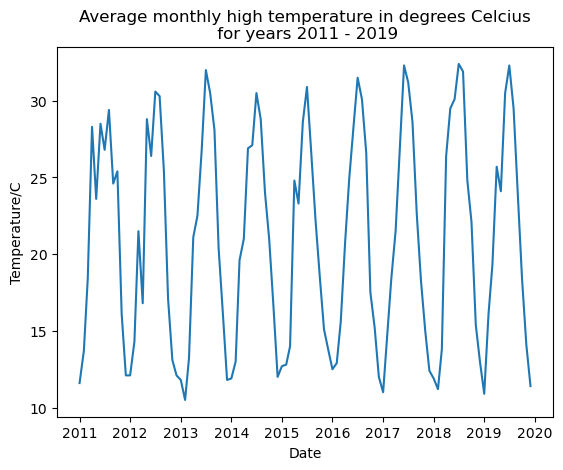

In [3]:
# plot the data
fig, ax = plt.subplots()

ax.plot(df.date, df.test)
ax.set_xlabel('Date')
ax.set_ylabel('Temperature/C')
ax.set_title("Average monthly high temperature in degrees Celcius\n for years 2011 - 2019");

As this is yearly data, let's see the data at each year

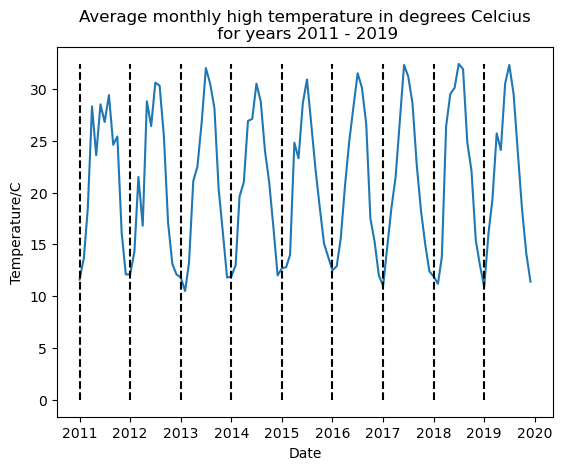

In [4]:
# plot data with vertical lines at seasonal frequency e.g. 12 months if looking at years
line_range = [df.date[i] for i in range(0,len(df),12)]

fig, ax = plt.subplots()

ax.plot(df.date, df.test)
for i in line_range:
    ax.vlines(i,0,max(df.test), colors='k',linestyles='dashed')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature/C')
ax.set_title("Average monthly high temperature in degrees Celcius\n for years 2011 - 2019");

From this graph the seasonal trends are quite clear to see. We can use decomposition to view the original data, the trends, the seasonal effects and the residuals below.

# Decomposition of the data

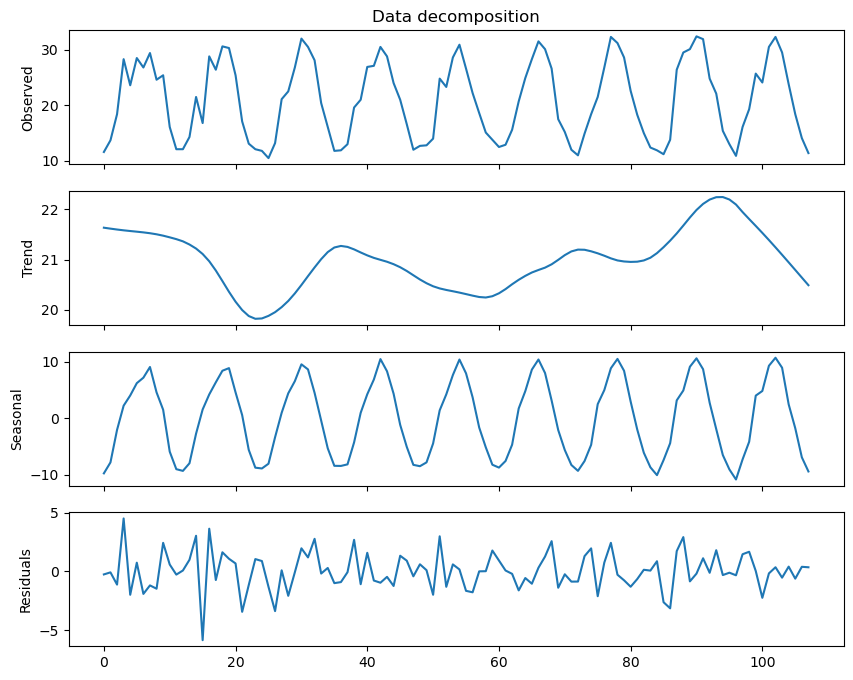

In [5]:
# get decomposition of the data
decomposition = STL(df.test, period=12).fit()

# graph the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True,figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')
ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')
ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')
ax1.set_title("Data decomposition");

From the graph of decomposition data, it is clear to see that there is a seasonal effect on this data (there is a repeating pattern through time). The residual graph shows any differences that cannot easily be explained by the trend or seasonality.

Data with no seasonality would have a flat line on the Seasonal graph.

# Check to see if it is stationary

The augmented Dickey-Fuller (ADF) test is used to see if a series is stationary or not by testing
for unit roots.

In [6]:
# check if it is stationary

# perform dickey-fuller test
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df.test, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -2.311328
p-value                         0.168340
#Lags Used                     10.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


The null hypothesis (H0) is that the data is not stationary.
The alternative hypothesis (H1) is that the data is stationary.
The test statistic is larger than (most of) the critical values and the p-value is larger than 0.05 so we cannot reject the null hypothesis and conclude the data is not stationary

# ARIMA approach - (p,d,q) model

p is the autoregressive process (AR)

d is the integration (I)

q is the moving average (MA)

# Apply data transformations if needed

From the Numpy manual (https://numpy.org/doc/stable/reference/generated/numpy.diff.html), The first difference is given by out[i] = a[i+1] - a[i] along the given axis, higher differences are calculated by using diff recursively

In [7]:
# Try first order differencing to see if this makes the data stationary

data_diff = np.diff(df.test, n=1) # n is the number of differencing terms

# repeat the dickey-fuller test

# perform dickey-fuller test
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(data_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -1.144568e+01
p-value                        6.027061e-21
#Lags Used                     9.000000e+00
Number of Observations Used    9.700000e+01
Critical Value (1%)           -3.499637e+00
Critical Value (5%)           -2.891831e+00
Critical Value (10%)          -2.582928e+00
dtype: float64


Now the test statistic and the p-value are less than the critical values and threshold of 0.05 respectively. Now we can conclude that the series is stationary and accept the alternate hypothesis, and can reject the null hypothesis that the series is non-stationary.

# Set d equal to the number of differences (integration)

In [8]:
d = 1 # if the differencing is repeated e.g. 2 or 3 times then d would need to be 2 or 3 respectively

# List values of p and q

In [9]:
# set a range of values to try for p and q
# d is a constant which is set to the number of differencing terms (integration)

p_try = range(0,4,1) # increment in +1 steps
q_try = range(0,4,1)

values_try = []

for i in p_try:
    for j in q_try:
        values_try.append([i,j])
        
values_try_df = pd.DataFrame(values_try)
values_try_df.columns = ['p','q']
print(values_try_df)

    p  q
0   0  0
1   0  1
2   0  2
3   0  3
4   1  0
5   1  1
6   1  2
7   1  3
8   2  0
9   2  1
10  2  2
11  2  3
12  3  0
13  3  1
14  3  2
15  3  3


# Train and test split the data

In [10]:
# because the differencing (integration) term d is used, we do not need to manipulate the dataframe data

time_lag = 12 # if there is any pattern to take into account for testing e.g. a 12 month season or no season at all
data_points_to_test_from = 4

train = df.test[:-(data_points_to_test_from)] # all data points except the last 4
test = df.test.iloc[-(data_points_to_test_from):] # from 4 data points before the end of the datapoints, to the end of the datapoints

# Fit every combination of p,d,q

In [11]:
# we have already set the value of d above, which is constant for this exercise
results = []
for eacher in range(0,len(values_try_df),1):
    # for each p and q value fit the model
    try:
        model = ARIMA(train, order=(values_try_df['p'][eacher],d,values_try_df['q'][eacher])).fit()
    except:
        continue
        
    # record the results
    aic = model.aic
    results.append([values_try_df['p'][eacher],values_try_df['q'][eacher],aic])
    
results_df = pd.DataFrame(results)
results_df.columns = ['p','q','aic']
    
# sort in descending order by aic score, as lower aic is better
results_df = results_df.sort_values(by='aic', ascending=True).reset_index(drop=True)

print(results_df)

    p  q         aic
0   2  3  473.351238
1   3  3  475.261250
2   3  2  494.381386
3   2  2  530.792920
4   3  1  535.323571
5   1  2  582.868942
6   1  3  583.975685
7   0  2  585.577483
8   3  0  585.917333
9   2  0  589.698825
10  2  1  589.753230
11  1  1  595.692927
12  0  3  595.948543
13  1  0  596.211216
14  0  1  599.750734
15  0  0  603.083024


# Select model with lowest AIC (Akaike information criterion)

The AIC is a measure of the quality of a given model relative to the other models. The AIC is a way of quantifying the information loss of a model when fitted to data, and determining which model has the lowest amount of information lost - hence having a lower AIC score. The lowest scoring AIC model is therefore the best performing model to use.

In [12]:
# select lowest aic score p and q value
p_use = results_df['p'][0]
q_use = results_df['q'][0]

print(f"the value of p to use is: {p_use}")
print(f"the value of q to use is: {q_use}")
print(f"the lowest model aic is: {results_df['aic'][0]}")

# fit the model
model = ARIMA(train,order=(p_use,d,q_use))
model_fit = model.fit()

the value of p to use is: 2
the value of q to use is: 3
the lowest model aic is: 473.3512379793419


# Residual analysis

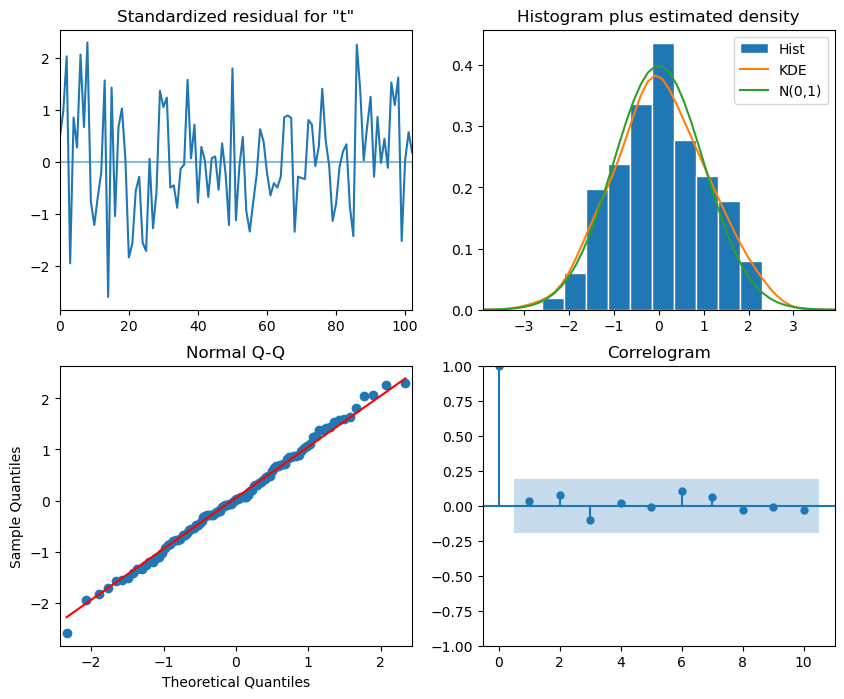

In [13]:
# check the dianostics and see if the plots are appropiate
model_fit.plot_diagnostics(figsize=(10,8));

# Check the plot diagnositics

# Standardized residual
The standard residual chart shows no apparent trend, and the mean seems fairly constant which implies that the residuals are likely stationary.

# Histogram
The histogram plot shows a shape similar to a normal distribution.

# Q-Q Plot
The datapoints on the quartile-quartile plot approximately lie straight (on the red, 45 degree line). This means that our data is normally distributed. If the data were not normally distributed, the datapoints would deviate from the reference, 45 degree red line.

# Correlogram
The autocorrelation plot shows no autocorrelation/significant variance after lag 0

# Conclusion
These plot diagnostics indicate that the residuals resemble random fluctuations (white noise), and so we can conclude that the residuals are normally distributed and uncorrelated.

# Check uncorrelated residuals

In [14]:
# perform a Ljung - box test on the residuals and check the p-value
residuals = model_fit.resid

ttt = acorr_ljungbox(residuals, np.arange(1, 11, 1), return_df=True)#np.arange(1, 11, 1))

print(ttt.lb_pvalue)

1     0.893550
2     0.324085
3     0.516766
4     0.603068
5     0.716025
6     0.583127
7     0.351964
8     0.451812
9     0.477767
10    0.492015
Name: lb_pvalue, dtype: float64


As the p-values are all greater than 0.05, we can accept the null hypothesis and conclude that the residuals are uncorrelated (and resemble something like white noise).

Now that we are happy the model has passed all of these checks, we can move on to forecasting.

# Forecast!

In [15]:
# forecast the test data split, and compare to a naive approach (repeating the previous 4 datapoints)

# actual data
test = df.iloc[-(data_points_to_test_from):]

# naive approach
test['naive'] = df.test.iloc[len(df)-(time_lag+(data_points_to_test_from)):len(df)-(time_lag)].values # the prior time_lag previous data points to the current time_lag datapoints

# ARIMA predictions
ARIMA_preds = model_fit.get_prediction(len(df)-(data_points_to_test_from),len(df)).predicted_mean

test['arima_pred'] = ARIMA_preds

Graph the results

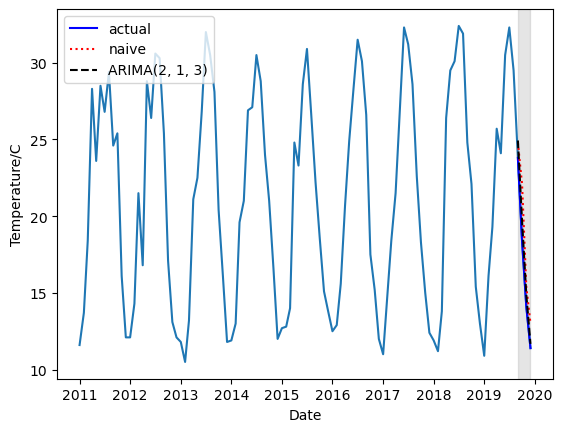

In [16]:
fig, ax = plt.subplots()

ax.plot(df['date'], df['test'])
ax.plot(test['date'], test['test'], 'b-', label='actual')
ax.plot(test['date'], test['naive'], 'r:', label='naive')
ax.plot(test['date'], test['arima_pred'], 'k--', label=f"ARIMA{p_use,d,q_use}")

ax.set_xlabel('Date')
ax.set_ylabel('Temperature/C')
ax.axvspan(df.date[len(df)-4],df.date[len(df)-1], color='#808080', alpha=0.2)

ax.legend(loc=2);

# Quantify the error on the test data

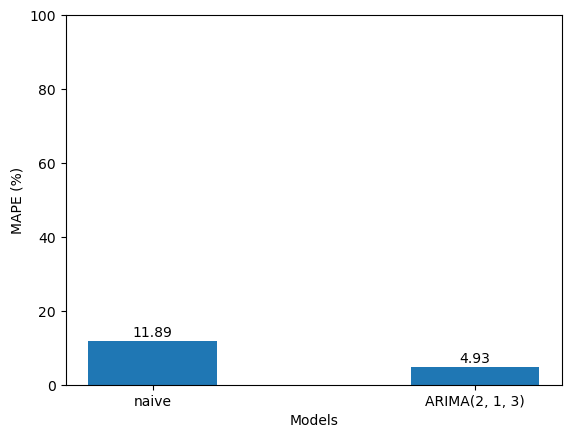

In [17]:
# We can quantify the mean absolute percentage error (MAPE) by comparing the real value to the predicted value

def mape_value (true_value, predicted_value):
    return np.mean(np.abs((true_value - predicted_value) / true_value)) * 100

naive_mape = mape_value(test['test'],test['naive'])
arima_mape = mape_value(test['test'],test['arima_pred'])

# graph this
fig, ax = plt.subplots()
x = ['naive', f"ARIMA{p_use,d,q_use}"]
y = [naive_mape, arima_mape]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 100)
for index, value in enumerate(y):
    ax.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

Here, we can see the error is much lower on the arima predictions.

# Forecast on future values

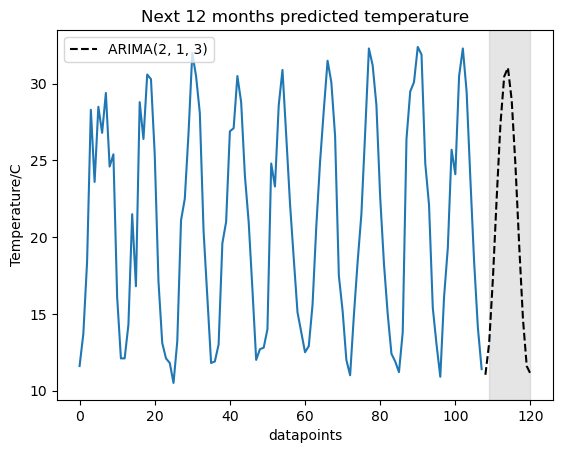

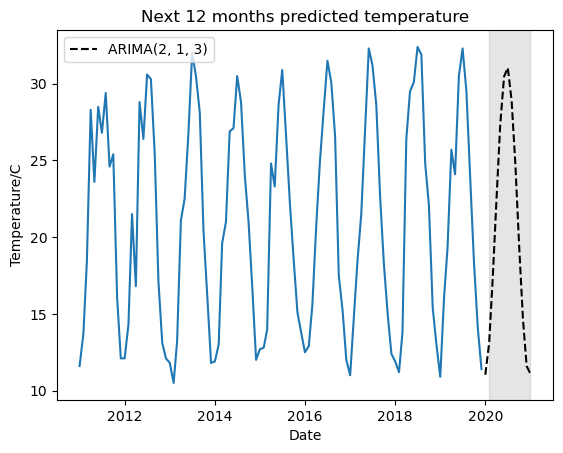

In [18]:
################## forecast future x datapoints ####################################
df_future = df.copy()

# future prediction forecast range
x = 12 # next 12 months

# make a df which has this range of values
df_future['index'] = df_future.index

# ARIMA predictions
ARIMA_preds = model_fit.get_prediction(len(df_future),len(df_future)+x).predicted_mean

test = pd.DataFrame({'arima_pred':ARIMA_preds})

# concat this onto df
df_future = pd.concat([df_future,test])

# graph this
fig, ax = plt.subplots()

ax.plot(df_future.index, df_future['test'])
ax.plot(df_future.index, df_future['arima_pred'], 'k--', label=f"ARIMA{p_use,d,q_use}")

ax.set_xlabel('datapoints')
ax.set_ylabel('Temperature/C')
ax.axvspan(df_future.index[len(df_future)-x],df_future.index[len(df_future)-1], color='#808080', alpha=0.2)
ax.set_title(f"Next {x} months predicted temperature")
ax.legend(loc=2);

################## forecast future x time ####################################
df_future = df.copy()

# future prediction forecast range
x = 12 # next 12 months

# make a daterange of this
dates_to_add = []

last_date = df.date[-1:].reset_index()
last_date = last_date['date'][0]

for iii in range(1,x+2,1):
    dater = last_date+pd.DateOffset(months=iii) # or days, years etc
    dater = pd.Timestamp(dater).to_pydatetime()
    dates_to_add.append(dater)
    
dates_to_add = pd.DataFrame({'date':dates_to_add})

# make a df which has this range of values
df_future['index'] = df_future.index

# ARIMA predictions
ARIMA_preds = model_fit.get_prediction(len(df_future),len(df_future)+x).predicted_mean


test = pd.DataFrame({'arima_pred':ARIMA_preds})

dates_to_add.index = test.index

#test = pd.concat([test,dates_to_add],axis=1)
test['date'] = dates_to_add['date']

# concat this onto df
df_future = pd.concat([df_future,test])
df_future['index'] = df_future.index

# graph this
fig, ax = plt.subplots()

ax.plot(df_future['date'], df_future['test'])
ax.plot(df_future['date'], df_future['arima_pred'], 'k--', label=f"ARIMA{p_use,d,q_use}")

ax.set_xlabel('Date')
ax.set_ylabel('Temperature/C')
ax.axvspan(df_future.date[len(df_future)-x],df_future.date[len(df_future)-1], color='#808080', alpha=0.2)
ax.set_title(f"Next {x} months predicted temperature")
ax.legend(loc=2);

 # SARIMA (and ARIMA) approach (typically the better approach to use)
 
SARIMA = (p,d,q)(P,D,Q,m) * m can be replaced by s

ARIMA = (p,d,q)(P,D,Q,m) * m can be replaced by s

In both of these cases:

p is the autoregressive process (AR)

d is the integration (I)

q is the moving average (MA)

P is the seasonal autoregressive process (AR)

D is the seasonal integration (I)

Q is the seasonal moving average (MA)

m is the frequency (number of observations) per period

Heading back to the first Dickey-Fuller test to check for stationarity, it was found that the data was not stationary, and therefore we need to try data differencing.

Because we are now looking at the SARIMA model, we can actually model both the SARIMA and ARIMA model with the same approach. An ARIMA model can also be thought of/ used as a SARIMA model with no seasonal effects.

# Apply data transformations if needed

From the Numpy manual (https://numpy.org/doc/stable/reference/generated/numpy.diff.html), The first difference is given by out[i] = a[i+1] - a[i] along the given axis, higher differences are calculated by using diff recursively

Because we are now using the SARIMA approach, we need to specify additional differencing parameters, as below.

In [19]:
# ARIMA approach (same as before)

# Try first order differencing to see if this makes the data stationary
data_diff = np.diff(df.test, n=1) # n is the number of differencing terms

# repeat the dickey-fuller test

# perform dickey-fuller test
print ('Results of Dickey-Fuller Test (ARIMA):')
dftest = adfuller(data_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

# SARIMA approach
# Try first order differencing to see if this makes the data stationary
data_diff_season = np.diff(df.test, n=12) # n is the number of seasonal differences e.g. 12 months in a year

# repeat the dickey-fuller test

# perform dickey-fuller test
print ('Results of Dickey-Fuller Test (SARIMA seasonal):')
dftest = adfuller(data_diff_season, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)


Results of Dickey-Fuller Test (ARIMA):
Test Statistic                -1.144568e+01
p-value                        6.027061e-21
#Lags Used                     9.000000e+00
Number of Observations Used    9.700000e+01
Critical Value (1%)           -3.499637e+00
Critical Value (5%)           -2.891831e+00
Critical Value (10%)          -2.582928e+00
dtype: float64
Results of Dickey-Fuller Test (SARIMA seasonal):
Test Statistic                -1.231739e+01
p-value                        6.872530e-23
#Lags Used                     1.200000e+01
Number of Observations Used    8.300000e+01
Critical Value (1%)           -3.511712e+00
Critical Value (5%)           -2.897048e+00
Critical Value (10%)          -2.585713e+00
dtype: float64


In both of these results, the test statistics is less than the critical values and the p-value is less than 0.05. This means we can reject the null hypothesis (H0) that the data is not stationary, and instead accept the alternate hypothesis (H1) that the data is stationary.

# Set the values of d and D (and s)

In [20]:
d = 1 # this is the number of times the data was differenced
D_ARIMA = 0 # this is  0 for ARIMA models since seasonality is not taken into account
D_SARIMA = 1 # this is the number of times the data was seasonally differenced

s = 12 # s is also known as m in the SARIMA model (p,d,q)(P,D,Q,s(or m)) - it is simply the frequency of the seasons e.g. every 12 months in a year

# List values of p, q and P, Q  for ARIMA approach

In [21]:
# set a range of values to try for p and q
# d is a constant which is set to the number of differencing terms (integration)
# D is also a constant which is set to the seasonal differencing

p_try_ARIMA = range(0,4,1) # increment in +1 steps
q_try_ARIMA = range(0,4,1)

P_try_ARIMA = 0 # 0 as not needed for ARIMA model
Q_try_ARIMA = 0 # 0 as not needed for ARIMA model

values_try_ARIMA_pq = []

for i in p_try_ARIMA:
    for j in q_try_ARIMA:
        values_try_ARIMA_pq.append([i,j])
        
values_try_df_ARIMA_pq = pd.DataFrame(values_try_ARIMA_pq)
values_try_df_ARIMA_pq.columns = ['p','q']

values_try_ARIMA_df = values_try_df_ARIMA_pq
values_try_ARIMA_df['P'] = P_try_ARIMA
values_try_ARIMA_df['Q'] = Q_try_ARIMA

# the below code is not needed for ARIMA implementation of SARIMA

#values_try_ARIMA_PQ = []

#for i in P_try_ARIMA:
#    for j in Q_try_ARIMA:
#        values_try_ARIMA_PQ.append([i,j])
        
#values_try_df_ARIMA_PQ = pd.DataFrame(values_try_ARIMA_PQ)
#values_try_df_ARIMA_PQ.columns = ['P','Q']

# combine these together
#values_try_ARIMA = pd.concat([values_try_df_ARIMA_pq,values_try_df_ARIMA_PQ],axis=1)

print(values_try_ARIMA_df)

    p  q  P  Q
0   0  0  0  0
1   0  1  0  0
2   0  2  0  0
3   0  3  0  0
4   1  0  0  0
5   1  1  0  0
6   1  2  0  0
7   1  3  0  0
8   2  0  0  0
9   2  1  0  0
10  2  2  0  0
11  2  3  0  0
12  3  0  0  0
13  3  1  0  0
14  3  2  0  0
15  3  3  0  0


# Train, test and split the data

In [22]:
# because the differencing (integration) term d is used, we do not need to manipulate the dataframe data

time_lag = 12 # if there is any pattern to take into account for testing e.g. a 12 month season or no season at all
data_points_to_test_from = 4

train = df.test[:-(data_points_to_test_from)] # all data points except the last 4
test = df.test.iloc[-(data_points_to_test_from):] # from 4 data points before the end of the datapoints, to the end of the datapoints

# Fit every combination of p,d,q and P,D,Q for ARIMA

In [23]:
# we have already set the value of d and D above, which are both constant for this exercise
results_ARIMA = []
for eacher in range(0,len(values_try_ARIMA_df),1):
    # for each p and q value fit the model
    try:
        model_ARIMA = SARIMAX(train, order=(values_try_ARIMA_df['p'][eacher],d,values_try_ARIMA_df['q'][eacher]),seasonal_order=(values_try_ARIMA_df['P'][eacher],D_ARIMA,values_try_ARIMA_df['Q'][eacher],s)).fit()
    except:
        continue
        
    # record the results
    aic_ARIMA = model_ARIMA.aic
    results_ARIMA.append([values_try_ARIMA_df['p'][eacher],values_try_ARIMA_df['q'][eacher],values_try_ARIMA_df['P'][eacher],values_try_ARIMA_df['Q'][eacher],aic_ARIMA])
    
results_df_ARIMA = pd.DataFrame(results_ARIMA)
results_df_ARIMA.columns = ['p','q','P','Q','aic']
    
# sort in descending order by aic score, as lower aic is better
results_df_ARIMA = results_df_ARIMA.sort_values(by='aic', ascending=True).reset_index(drop=True)

print(results_df_ARIMA)

    p  q  P  Q         aic
0   2  3  0  0  473.351238
1   3  3  0  0  475.261250
2   3  2  0  0  494.381386
3   2  2  0  0  530.792920
4   3  1  0  0  535.323571
5   1  2  0  0  582.868942
6   1  3  0  0  583.975685
7   0  2  0  0  585.577483
8   3  0  0  0  585.917333
9   2  0  0  0  589.698825
10  2  1  0  0  589.753230
11  1  1  0  0  595.692927
12  0  3  0  0  595.948543
13  1  0  0  0  596.211216
14  0  1  0  0  599.750734
15  0  0  0  0  603.083024


# List values of p, q and P, Q  for SARIMA approach

In [24]:
# set a range of values to try for p and q
# d is a constant which is set to the number of differencing terms (integration)
# D is also a constant which is set to the seasonal differencing

p_try_SARIMA = range(0,4,1) # increment in +1 steps
q_try_SARIMA = range(0,4,1)

P_try_SARIMA = range(0,4,1)
Q_try_SARIMA = range(0,4,1)

values_try_SARIMA_pq = []

for i in p_try_SARIMA:
    for j in q_try_SARIMA:
        values_try_SARIMA_pq.append([i,j])
        
values_try_df_SARIMA_pq = pd.DataFrame(values_try_SARIMA_pq)
values_try_df_SARIMA_pq.columns = ['p','q']

values_try_SARIMA_PQ = []

for i in P_try_SARIMA:
    for j in Q_try_SARIMA:
        values_try_SARIMA_PQ.append([i,j])
        
values_try_df_SARIMA_PQ = pd.DataFrame(values_try_SARIMA_PQ)
values_try_df_SARIMA_PQ.columns = ['P','Q']

# combine these together
values_try_SARIMA_df = pd.concat([values_try_df_SARIMA_pq,values_try_df_SARIMA_PQ],axis=1)

print(values_try_SARIMA_df)

    p  q  P  Q
0   0  0  0  0
1   0  1  0  1
2   0  2  0  2
3   0  3  0  3
4   1  0  1  0
5   1  1  1  1
6   1  2  1  2
7   1  3  1  3
8   2  0  2  0
9   2  1  2  1
10  2  2  2  2
11  2  3  2  3
12  3  0  3  0
13  3  1  3  1
14  3  2  3  2
15  3  3  3  3


# Train, test and split the data

In [25]:
# because the differencing (integration) term d is used, we do not need to manipulate the dataframe data

time_lag = 12 # if there is any pattern to take into account for testing e.g. a 12 month season or no season at all
data_points_to_test_from = 4

train = df.test[:-(data_points_to_test_from)] # all data points except the last 4
test = df.test.iloc[-(data_points_to_test_from):] # from 4 data points before the end of the datapoints, to the end of the datapoints

# Fit every combination of p,d,q and P,D,Q for SARIMA

In [26]:
# we have already set the value of d and D above, which are both constant for this exercise
results_SARIMA = []
for eacher in range(0,len(values_try_SARIMA_df),1):
    # for each p and q value fit the model
    try:
        model_SARIMA = SARIMAX(train, order=(values_try_SARIMA_df['p'][eacher],d,values_try_SARIMA_df['q'][eacher]),seasonal_order=(values_try_SARIMA_df['P'][eacher],D_SARIMA,values_try_SARIMA_df['Q'][eacher],s)).fit()
    except:
        continue
        
    # record the results
    aic_SARIMA = model_SARIMA.aic
    results_SARIMA.append([values_try_SARIMA_df['p'][eacher],values_try_SARIMA_df['q'][eacher],values_try_SARIMA_df['P'][eacher],values_try_SARIMA_df['Q'][eacher],aic_SARIMA])
    
results_df_SARIMA = pd.DataFrame(results_SARIMA)
results_df_SARIMA.columns = ['p','q','P','Q','aic']
    
# sort in descending order by aic score, as lower aic is better
results_df_SARIMA = results_df_SARIMA.sort_values(by='aic', ascending=True).reset_index(drop=True)

print(results_df_SARIMA)

    p  q  P  Q         aic
0   2  3  2  3  427.168516
1   3  3  3  3  428.861782
2   0  2  0  2  429.616957
3   1  1  1  1  430.226175
4   0  3  0  3  430.895302
5   0  1  0  1  432.286444
6   2  1  2  1  432.334514
7   1  2  1  2  432.984440
8   3  1  3  1  433.196532
9   1  3  1  3  434.214690
10  2  2  2  2  434.511997
11  3  0  3  0  445.087395
12  3  2  3  2  448.680390
13  2  0  2  0  450.694777
14  1  0  1  0  461.069827
15  0  0  0  0  538.594321


This aic score is the lowest we have seen so far, which seems to suggest the SARIMA model is the way to go. let's compare the ARIMA and SARIMA model diagnostics, and Ljung-Box test results below.

# Fit the models with the lowest AIC score

The AIC is a measure of the quality of a given model relative to the other models. The AIC is a way of quantifying the information loss of a model when fitted to data, and determining which model has the lowest amount of information lost - hence having a lower AIC score. The lowest scoring AIC model is therefore the best performing model to use.

In [27]:
# ARIMA model
# select lowest aic score p and q value
p_use_ARIMA = results_df_ARIMA['p'][0]
q_use_ARIMA = results_df_ARIMA['q'][0]
P_use_ARIMA = results_df_ARIMA['P'][0]
Q_use_ARIMA = results_df_ARIMA['Q'][0]

print(f"the value of p to use for ARIMA is: {p_use_ARIMA}")
print(f"the value of q to use for ARIMA is: {q_use_ARIMA}")
print(f"the value of P to use for ARIMA is: {P_use_ARIMA}")
print(f"the value of Q to use for ARIMA is: {Q_use_ARIMA}")
print(f"the lowest model aic for ARIMA is: {results_df_ARIMA['aic'][0]}")

# fit the model
model_ARIMA = SARIMAX(train,order=(p_use_ARIMA,d,q_use_ARIMA),seasonal_order=(P_use_ARIMA,D_ARIMA,Q_use_ARIMA,s))
model_ARIMA_fit = model_ARIMA.fit()

# SARIMA model
# select lowest aic score p and q value
p_use_SARIMA = results_df_SARIMA['p'][0]
q_use_SARIMA = results_df_SARIMA['q'][0]
P_use_SARIMA = results_df_SARIMA['P'][0]
Q_use_SARIMA = results_df_SARIMA['Q'][0]

print(f"the value of p to use for SARIMA is: {p_use_SARIMA}")
print(f"the value of q to use for SARIMA is: {q_use_SARIMA}")
print(f"the value of P to use for SARIMA is: {P_use_SARIMA}")
print(f"the value of Q to use for SARIMA is: {Q_use_SARIMA}")
print(f"the lowest model aic for SARIMA is: {results_df_SARIMA['aic'][0]}")

# fit the model
model_SARIMA = SARIMAX(train,order=(p_use_SARIMA,d,q_use_SARIMA),seasonal_order=(P_use_SARIMA,D_SARIMA,Q_use_SARIMA,s))
model_SARIMA_fit = model_SARIMA.fit()

the value of p to use for ARIMA is: 2
the value of q to use for ARIMA is: 3
the value of P to use for ARIMA is: 0
the value of Q to use for ARIMA is: 0
the lowest model aic for ARIMA is: 473.3512379793419
the value of p to use for SARIMA is: 2
the value of q to use for SARIMA is: 3
the value of P to use for SARIMA is: 2
the value of Q to use for SARIMA is: 3
the lowest model aic for SARIMA is: 427.16851638354973


# ARIMA model diagnostics

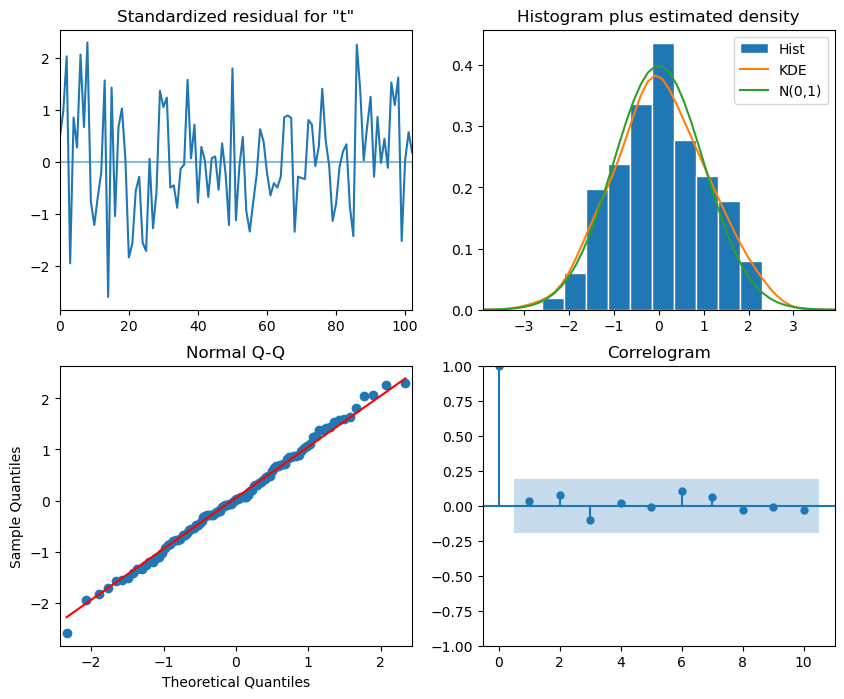

In [28]:
model_ARIMA_fit.plot_diagnostics(figsize=(10,8));

This plot looks largely similar to the first ARIMA diagnosics plot, and so won't be commented on. Let's plot the SARIMA model diagnostics below.

# SARIMA model diagnostics

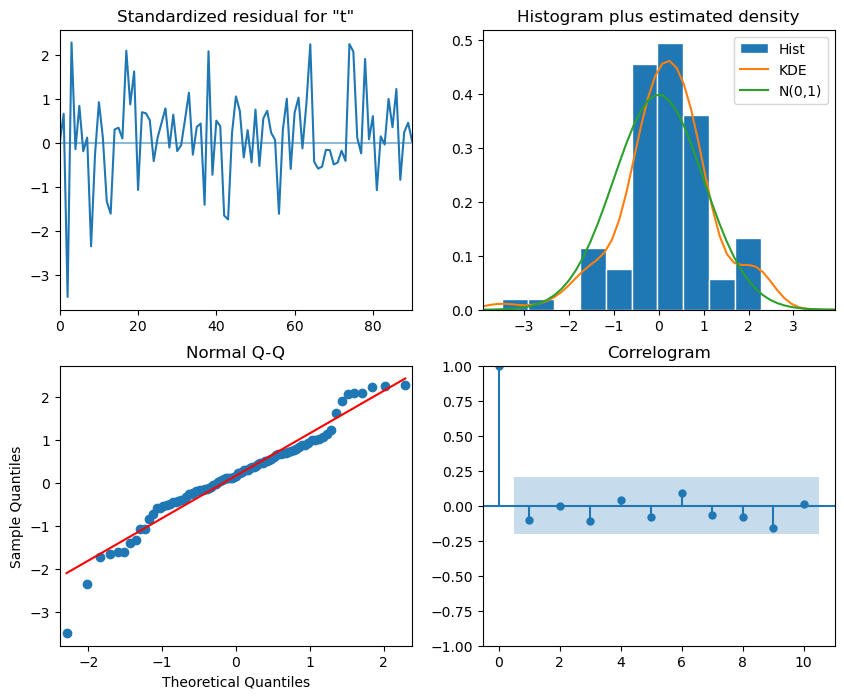

In [29]:
model_SARIMA_fit.plot_diagnostics(figsize=(10,8));

# Check the plot diagnositics

Standardized residual

The standard residual chart shows no apparent trend, and the mean seems fairly constant which implies that the residuals are likely stationary.

Histogram

The histogram plot shows a shape similar to a normal distribution.

Q-Q Plot

The datapoints on the quartile-quartile plot approximately lie straight (on the red, 45 degree line). This means that our data is normally distributed. If the data were not normally distributed, the datapoints would deviate from the reference, 45 degree red line.

Correlogram

The autocorrelation plot shows no autocorrelation/significant variance after lag 0

Conclusion

These plot diagnostics indicate that the residuals resemble random fluctuations (white noise), and so we can conclude that the residuals are normally distributed and uncorrelated.

# Ljung-Box test on both ARIMA and SARIMA models

In [30]:
#  ARIMA model
# perform a Ljung - box test on the residuals and check the p-value
residuals_ARIMA = model_ARIMA_fit.resid

ttt_ARIMA = acorr_ljungbox(residuals_ARIMA, np.arange(1, 11, 1), return_df=True)#np.arange(1, 11, 1))

print("ARIMA model Ljung-Box test results:")
print(ttt_ARIMA.lb_pvalue)

#  SARIMA model
# perform a Ljung - box test on the residuals and check the p-value
residuals_SARIMA = model_SARIMA_fit.resid

print("SARIMA model Ljung-Box test results:")
ttt_SARIMA = acorr_ljungbox(residuals_SARIMA, np.arange(1, 11, 1), return_df=True)#np.arange(1, 11, 1))

print(ttt_SARIMA.lb_pvalue)

ARIMA model Ljung-Box test results:
1     0.893550
2     0.324085
3     0.516766
4     0.603068
5     0.716025
6     0.583127
7     0.351964
8     0.451812
9     0.477767
10    0.492015
Name: lb_pvalue, dtype: float64
SARIMA model Ljung-Box test results:
1     0.346606
2     0.053667
3     0.110908
4     0.169671
5     0.267117
6     0.376081
7     0.488721
8     0.104521
9     0.140304
10    0.059293
Name: lb_pvalue, dtype: float64


The null Hypothesis (H0) is that the residuals are uncorrelated and independent, like random white noise.
The alternate Hypothesis (H1) is that the residuals are correlated and dependent.

For the ARIMA model, all of the results are above the 0.05 p-value threshold, which means we accept the null hypothesis (H0) and conclude the residuals are uncorrelated and independent.

For the SARIMA model, all of the results also meet this criteria (that all values are above the p-value threshold of 0.05) however points 2 and 10 are very close to the 0.05 value. If they were to be less than 0.05, then we would only be able to conclude with 95% certainty that we accept the null hypothesis (H0).

# Forecast

In [31]:
# forecast the test data split, and compare to a naive approach (repeating the previous 4 datapoints)

# actual data
test_season = df.iloc[-(data_points_to_test_from):]

# naive approach
test_season['naive'] = df.test.iloc[len(df)-(time_lag+(data_points_to_test_from)):len(df)-(time_lag)].values # the prior time_lag previous data points to the current time_lag datapoints

# ARIMA predictions
ARIMA_preds_season = model_ARIMA_fit.get_prediction(len(df)-(data_points_to_test_from),len(df)).predicted_mean

test_season['arima_pred'] = ARIMA_preds_season

# SARIMA predictions
SARIMA_preds_season = model_SARIMA_fit.get_prediction(len(df)-(data_points_to_test_from),len(df)).predicted_mean

test_season['sarima_pred'] = SARIMA_preds_season

Graph the results

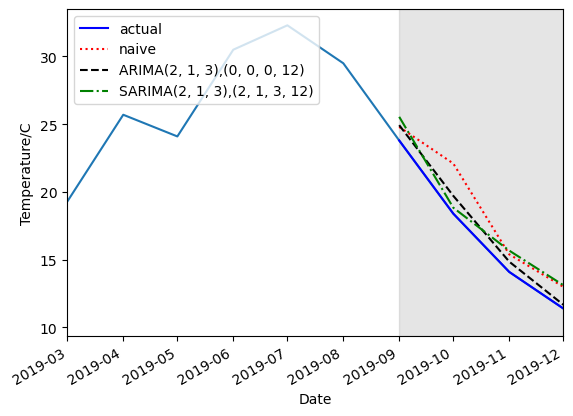

In [32]:
fig, ax = plt.subplots()

ax.plot(df['date'], df['test'])
ax.plot(test_season['date'], test_season['test'], 'b-', label='actual')
ax.plot(test_season['date'], test_season['naive'], 'r:', label='naive')
ax.plot(test_season['date'], test_season['arima_pred'], 'k--', label=f"ARIMA{p_use_ARIMA,d,q_use_ARIMA},{P_use_ARIMA,D_ARIMA,Q_use_ARIMA,s}")
ax.plot(test_season['date'], test_season['sarima_pred'], 'g-.', label=f"SARIMA{p_use_SARIMA,d,q_use_SARIMA},{P_use_SARIMA,D_SARIMA,Q_use_SARIMA,s}")

ax.set_xlabel('Date')
ax.set_ylabel('Temperature/C')
ax.axvspan(df.date[len(df)-4],df.date[len(df)-1], color='#808080', alpha=0.2)
ax.set_xlim(df.date[len(df)-10],df.date[len(df)-1]) # zoom in on test set

fig.autofmt_xdate()

ax.legend(loc=2);

# Measure the MAPE

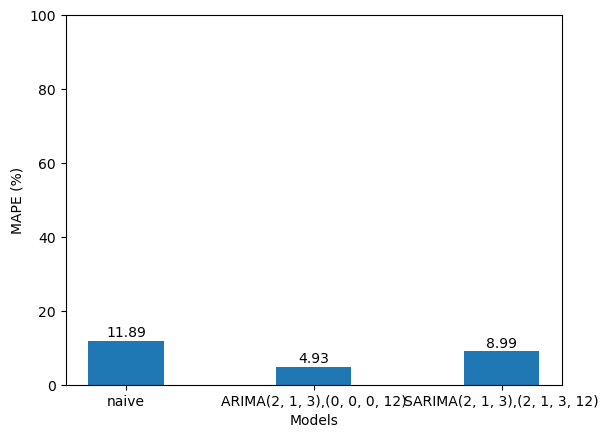

In [33]:
naive_mape_season = mape_value(test_season['test'],test_season['naive'])
arima_mape_season = mape_value(test_season['test'],test_season['arima_pred'])
sarima_mape_season = mape_value(test_season['test'],test_season['sarima_pred'])

# graph this
fig, ax = plt.subplots()
x = ['naive', f"ARIMA{p_use_ARIMA,d,q_use_ARIMA},{P_use_ARIMA,D_ARIMA,Q_use_ARIMA,s}",f"SARIMA{p_use_SARIMA,d,q_use_SARIMA},{P_use_SARIMA,D_SARIMA,Q_use_SARIMA,s}"]
y = [naive_mape_season, arima_mape_season,sarima_mape_season]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 100)
for index, value in enumerate(y):
    ax.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

On the testing data, the SARIMA performs worse when compared to the ARIMA but the SARIMA model had a lower AIC score than the ARIMA model. Let's see how the predictions compare for the next 12 months.

# Forecast on future values

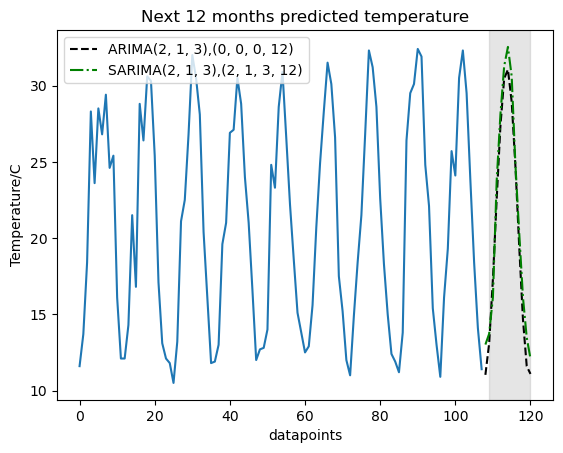

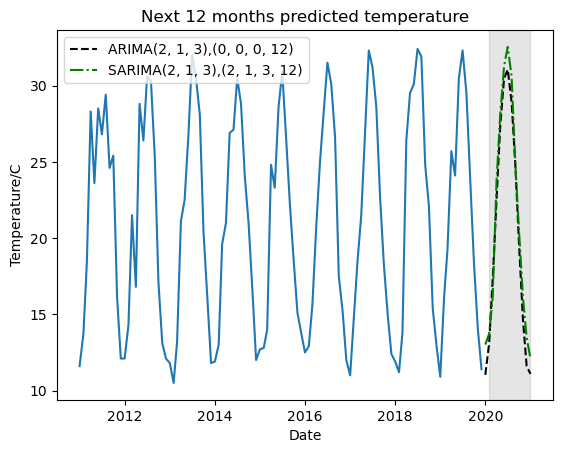

In [34]:
################## forecast future x points ####################################
df_future_season = df.copy()

# future prediction forecast range
x = 12 # next 12 months

# make a df which has this range of values
df_future_season['index'] = df_future_season.index

# ARIMA predictions
ARIMA_preds_season = model_ARIMA_fit.get_prediction(len(df_future_season),len(df_future_season)+x).predicted_mean

# SARIMA predictions
SARIMA_preds_season = model_SARIMA_fit.get_prediction(len(df_future_season),len(df_future_season)+x).predicted_mean

test_season_ARIMA = pd.DataFrame({'arima_pred':ARIMA_preds_season})
test_season_SARIMA = pd.DataFrame({'sarima_pred':SARIMA_preds_season})

# concat this onto df
models = pd.concat([test_season_ARIMA,test_season_SARIMA],axis=1)
df_future_season = pd.concat([df_future_season,models])


# graph this
fig, ax = plt.subplots()

ax.plot(df_future_season.index, df_future_season['test'])
ax.plot(df_future_season.index, df_future_season['arima_pred'], 'k--', label=f"ARIMA{p_use_ARIMA,d,q_use_ARIMA},{P_use_ARIMA,D_ARIMA,Q_use_ARIMA,s}")
ax.plot(df_future_season.index, df_future_season['sarima_pred'], 'g-.', label=f"SARIMA{p_use_SARIMA,d,q_use_SARIMA},{P_use_SARIMA,D_SARIMA,Q_use_SARIMA,s}")

ax.set_xlabel('datapoints')
ax.set_ylabel('Temperature/C')
ax.axvspan(df_future_season.index[len(df_future_season)-x],df_future_season.index[len(df_future_season)-1], color='#808080', alpha=0.2)
ax.set_title(f"Next {x} months predicted temperature")
ax.legend(loc=2);

################## forecast future x time ####################################
df_future_season = df.copy()

# future prediction forecast range
x = 12 # next 12 months

# make a daterange of this
dates_to_add = []

last_date = df.date[-1:].reset_index()
last_date = last_date['date'][0]

for iii in range(1,x+2,1):
    dater = last_date+pd.DateOffset(months=iii) # or days, years etc
    dater = pd.Timestamp(dater).to_pydatetime()
    dates_to_add.append(dater)
    
dates_to_add = pd.DataFrame({'date':dates_to_add})

# make a df which has this range of values
df_future_season['index'] = df_future_season.index

# ARIMA predictions
ARIMA_preds_season = model_ARIMA_fit.get_prediction(len(df_future_season),len(df_future_season)+x).predicted_mean

# SARIMA predictions
SARIMA_preds_season = model_SARIMA_fit.get_prediction(len(df_future_season),len(df_future_season)+x).predicted_mean

test_season_ARIMA = pd.DataFrame({'arima_pred':ARIMA_preds_season})
test_season_SARIMA = pd.DataFrame({'sarima_pred':SARIMA_preds_season})

dates_to_add.index = test_season_ARIMA.index

#test_season_ARIMA = pd.concat([test_season_ARIMA,dates_to_add],axis=1)
test_season_ARIMA['date'] = dates_to_add['date']
#test_season_SARIMA['date'] = dates_to_add['date']

# concat this onto df
models = pd.concat([test_season_ARIMA,test_season_SARIMA],axis=1)
df_future_season = pd.concat([df_future_season,models])
df_future_season['index'] = df_future_season.index

# graph this
fig, ax = plt.subplots()

ax.plot(df_future_season['date'], df_future_season['test'])
ax.plot(df_future_season['date'], df_future_season['arima_pred'], 'k--', label=f"ARIMA{p_use_ARIMA,d,q_use_ARIMA},{P_use_ARIMA,D_ARIMA,Q_use_ARIMA,s}")
ax.plot(df_future_season['date'], df_future_season['sarima_pred'], 'g-.', label=f"SARIMA{p_use_SARIMA,d,q_use_SARIMA},{P_use_SARIMA,D_SARIMA,Q_use_SARIMA,s}")

ax.set_xlabel('Date')
ax.set_ylabel('Temperature/C')
ax.axvspan(df_future_season.date[len(df_future_season)-x],df_future_season.date[len(df_future_season)-1], color='#808080', alpha=0.2)
ax.set_title(f"Next {x} months predicted temperature")
ax.legend(loc=2);

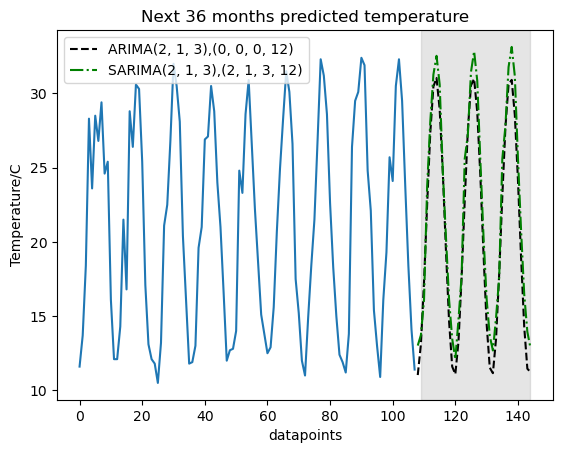

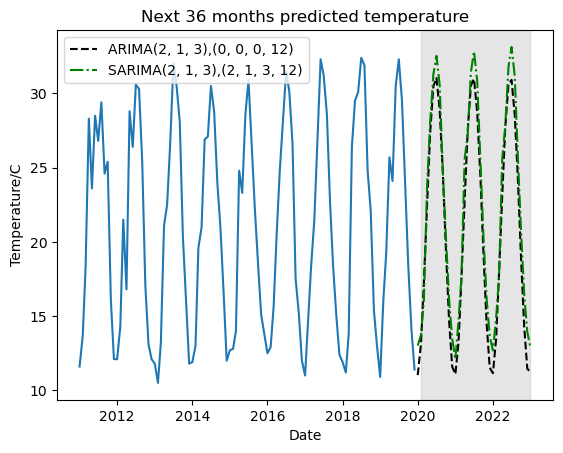

In [35]:
################## forecast future x points ####################################
df_future_season = df.copy()

# future prediction forecast range
x = 36 # next 36 months

# make a df which has this range of values
df_future_season['index'] = df_future_season.index

# ARIMA predictions
ARIMA_preds_season = model_ARIMA_fit.get_prediction(len(df_future_season),len(df_future_season)+x).predicted_mean

# SARIMA predictions
SARIMA_preds_season = model_SARIMA_fit.get_prediction(len(df_future_season),len(df_future_season)+x).predicted_mean

test_season_ARIMA = pd.DataFrame({'arima_pred':ARIMA_preds_season})
test_season_SARIMA = pd.DataFrame({'sarima_pred':SARIMA_preds_season})

# concat this onto df
models = pd.concat([test_season_ARIMA,test_season_SARIMA],axis=1)
df_future_season = pd.concat([df_future_season,models])


# graph this
fig, ax = plt.subplots()

ax.plot(df_future_season.index, df_future_season['test'])
ax.plot(df_future_season.index, df_future_season['arima_pred'], 'k--', label=f"ARIMA{p_use_ARIMA,d,q_use_ARIMA},{P_use_ARIMA,D_ARIMA,Q_use_ARIMA,s}")
ax.plot(df_future_season.index, df_future_season['sarima_pred'], 'g-.', label=f"SARIMA{p_use_SARIMA,d,q_use_SARIMA},{P_use_SARIMA,D_SARIMA,Q_use_SARIMA,s}")

ax.set_xlabel('datapoints')
ax.set_ylabel('Temperature/C')
ax.axvspan(df_future_season.index[len(df_future_season)-x],df_future_season.index[len(df_future_season)-1], color='#808080', alpha=0.2)
ax.set_title(f"Next {x} months predicted temperature")
ax.legend(loc=2);

################## forecast future x time ####################################
df_future_season = df.copy()

# future prediction forecast range
x = 36 # next 36 months

# make a daterange of this
dates_to_add = []

last_date = df.date[-1:].reset_index()
last_date = last_date['date'][0]

for iii in range(1,x+2,1):
    dater = last_date+pd.DateOffset(months=iii) # or days, years etc
    dater = pd.Timestamp(dater).to_pydatetime()
    dates_to_add.append(dater)
    
dates_to_add = pd.DataFrame({'date':dates_to_add})

# make a df which has this range of values
df_future_season['index'] = df_future_season.index

# ARIMA predictions
ARIMA_preds_season = model_ARIMA_fit.get_prediction(len(df_future_season),len(df_future_season)+x).predicted_mean

# SARIMA predictions
SARIMA_preds_season = model_SARIMA_fit.get_prediction(len(df_future_season),len(df_future_season)+x).predicted_mean

test_season_ARIMA = pd.DataFrame({'arima_pred':ARIMA_preds_season})
test_season_SARIMA = pd.DataFrame({'sarima_pred':SARIMA_preds_season})

dates_to_add.index = test_season_ARIMA.index

#test_season_ARIMA = pd.concat([test_season_ARIMA,dates_to_add],axis=1)
test_season_ARIMA['date'] = dates_to_add['date']
#test_season_SARIMA['date'] = dates_to_add['date']

# concat this onto df
models = pd.concat([test_season_ARIMA,test_season_SARIMA],axis=1)
df_future_season = pd.concat([df_future_season,models])
df_future_season['index'] = df_future_season.index

# graph this
fig, ax = plt.subplots()

ax.plot(df_future_season['date'], df_future_season['test'])
ax.plot(df_future_season['date'], df_future_season['arima_pred'], 'k--', label=f"ARIMA{p_use_ARIMA,d,q_use_ARIMA},{P_use_ARIMA,D_ARIMA,Q_use_ARIMA,s}")
ax.plot(df_future_season['date'], df_future_season['sarima_pred'], 'g-.', label=f"SARIMA{p_use_SARIMA,d,q_use_SARIMA},{P_use_SARIMA,D_SARIMA,Q_use_SARIMA,s}")

ax.set_xlabel('Date')
ax.set_ylabel('Temperature/C')
ax.axvspan(df_future_season.date[len(df_future_season)-x],df_future_season.date[len(df_future_season)-1], color='#808080', alpha=0.2)
ax.set_title(f"Next {x} months predicted temperature")
ax.legend(loc=2);

This second set of graphs is perhaps more insightful than the first - it shows that the ARIMA model is likely to predict unwavering future predictions, whereas the SARIMA model seems to increase predictions year-on-year slightly (perhaps it knows something about climate change and global warming...) this is due to the extra P,D and Q parameters, and this increasing trend over times does seem to follow the historical data. Whilst the MAPE was higher on the SARIMA model, for longer-term predictions it might be the better model to use.